PDF 是一种排版、印刷优化的格式。它不同于 HTML 这样现代格式，诞生之处的目的在于将纸质印刷品完全正确的数字化。作为一种数字格式，单依旧存在分页这个属性则很好的说明了这一点。

In [4]:
import pikepdf
import sys
from pathlib import Path
import jsonlines
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
df = pd.read_json('output/result.jsonl', orient='records', lines=True)

KeyboardInterrupt: 

In [3]:
non_null_count = df.count()
ratio = non_null_count / len(df)
ratio

file_name                               1.000000
file_size                               1.000000
/Author                                 0.557461
/CreationDate                           0.952270
/Creator                                0.756815
                                          ...   
/Giro d'Italia con Delitto              0.000001
/IOFXGUIDEV4                            0.000001
/Il testimone                           0.000001
/Delfini                                0.000001
/Terminator Salvation - Dalle ceneri    0.000001
Length: 5539, dtype: float64

首先观察提取结果里究竟有哪些元信息

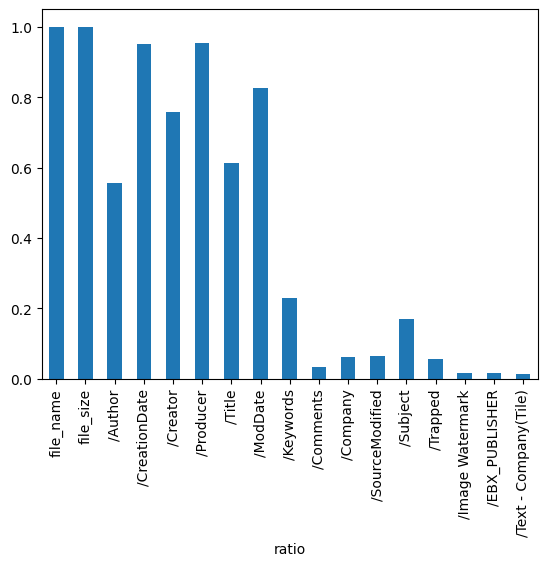

In [6]:
# 占比高的 meta info 字段
ratio[ratio>0.01].plot.bar()
plt.xlabel('ratio')
plt.show()

In [18]:
r = ratio[ratio>=0.2]

In [22]:
save_meta_info = [k for k in r.index]
save_meta_info

['file_name',
 'file_size',
 '/Author',
 '/CreationDate',
 '/Creator',
 '/Producer',
 '/Title',
 '/ModDate',
 '/Keywords']

由于每个 PDF 文件的 meta 信息数量不同，导致后续无法高效处理，因此将比例低于 0.2 的 metadata 合并成一个 字符串，同时记录每条数据的 meta 信息总数

In [29]:
import jsonlines
from tqdm import tqdm
with jsonlines.open("output/result.jsonl", "r") as reader:
    with jsonlines.open("output/newresult.jsonl", "w") as writer:
        for pdfinfo in tqdm(reader):
            newinfo = {}
            otherinfo = ""
            for k, v in pdfinfo.items():
                if k in save_meta_info:
                    newinfo.update({
                        k: v
                    })
                else:
                    otherinfo += f"{k}:{v};"
            newinfo.update({"others": otherinfo})
            writer.write(newinfo)
            del newinfo
            

0it [00:00, ?it/s]

634392it [00:05, 122581.06it/s]

- 除去提取时附带的 file_name 和 file_size 信息，占比最高的是 /CreationDate
- 其次是 /Producer 和 /Creator，二者的包含了导出/创建 PDF时使用的工具
- 余下信息为文档内容相关信息，除 Title 以外，其他信息占比都不高

PDF 是一种用于呈现信息的格式，它通常使用一些编辑软件如 Office 套件、LaTeX 乃至于浏览器生成。至少在导出阶段，PDF 文件表达了制作者的用途 —— 提交文件、作业和论文。因此，元信息中的 /Producer 与 /Creator 保存着PDF 的目的，如何创建意味着如何使用。

In [6]:
df = pd.read_json('output/all_metainfo_230916.jsonl', orient='records', lines=True)

## Producer
首先分析 Producer 下每种元信息的比例

In [10]:
df['/Producer'].count()
producer_null_count = df['/Producer'].value_counts()
ratio = producer_null_count / df['/Producer'].count()
ratio[ratio>0.01].plot.bar()
plt.xlabel('/Producer')
plt.show()

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/opt/homebrew/Caskroom/miniconda/base/envs/mmda/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3505, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/s5/r2cwx4h92v9cyrwvcnt5n45c0000gn/T/ipykernel_2364/1731018344.py", line 4, in <module>
    ratio[ratio>0.01].plot.bar()
  File "/opt/homebrew/Caskroom/miniconda/base/envs/mmda/lib/python3.8/site-packages/pandas/plotting/_core.py", line 1159, in bar
    :context: close-figs
  File "/opt/homebrew/Caskroom/miniconda/base/envs/mmda/lib/python3.8/site-packages/pandas/plotting/_core.py", line 920, in __call__
    return plot_backend.plot(data, x=x, y=y, kind=kind, **kwargs)
  File "/opt/homebrew/Caskroom/miniconda/base/envs/mmda/lib/python3.8/site-packages/pandas/plotting/_core.py", line 1886, in _get_plot_backend
  File "/opt/homebrew/Caskroom/miniconda/base/envs/mmda/lib/python3.8/site-packages/pandas/plotting/_core.py", line 1817, in _load_b

In [11]:
producer_df = df.dropna(subset='/Producer')
process_text_df = producer_df[producer_df['/Producer'].str.contains('ProcessText Group')]
process_text_df.to_json("output/contain_process_text.jsonl", orient='records', lines=True, force_ascii=False)

In [1]:
import json
import pathlib
from mmda.types import Document
from mmda.recipes import ProcessTextRecipe

def parse_to_jsonl(pdfs_path: str, output_path: str) -> None:
    pdfs_dir = pathlib.Path(pdfs_path)
    recipe = ProcessTextRecipe()
    with open(output_path, "w") as file:
        for pdf in pdfs_dir.iterdir():
            pdf_dir = pathlib.Path(pdf)
            print(pdf_dir)
            doc: Document = recipe.from_path(pdfpath=pdf_dir)
            doc_json = doc.to_json()
            json.dump(doc_json, file)
            file.write('\n')
            break

parse_to_jsonl("processtext", output_path="output/test_mmda.jsonl")

/opt/homebrew/Caskroom/miniconda/base/envs/mmda/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


processtext/23702.pdf


100%|██████████| 26/26 [00:14<00:00,  1.79it/s]


ProcessText Group 是什么
case by case 
data/14569.pdf
data/23702.pdf
data/19844.pdf
随便抽的几个 PDF 发现都是纯文字的英文 PDF
使用 mmda_mnbvc 中的基础 recipe 就可以很好的提取他们

根据观察元信息存在 “ProcessText Group” 的 PDF 为纯文本文件，因此在总 DF 中过滤元信息 /Producer 中有 “ProcessText Group” 字符的所有行

## Creator

/opt/homebrew/Caskroom/miniconda/base/envs/mmdp/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 25991 (\N{CJK UNIFIED IDEOGRAPH-6587}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/homebrew/Caskroom/miniconda/base/envs/mmdp/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 23383 (\N{CJK UNIFIED IDEOGRAPH-5B57}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


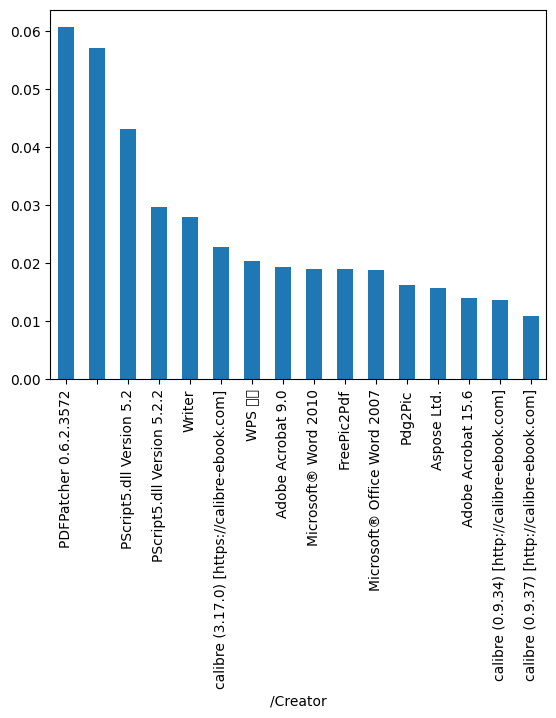

In [9]:
df['/Creator'].count()
producer_null_count = df['/Creator'].value_counts()
ratio = producer_null_count / df['/Creator'].count()
ratio[ratio>0.01].plot.bar()
plt.xlabel('/Creator')
plt.show()